Investigating using Convolutional Networks on Weak Lensing data
=============

Adpated from Assignment 4 of the Udacity course
------------



In [80]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['image.interpolation'] = 'none'
%matplotlib inline
from IPython import display

In [103]:
#pickle_file = 'notMNIST.pickle'
#pickle_file = '/Users/goldston/Documents/WL88.pickle'
usePickle = False

if usePickle:
    with open(pickle_file, 'rb') as f:
      save = pickle.load(f)
      train_dataset = save['train_dataset']
      train_labels = save['train_labels']
      valid_dataset = save['valid_dataset']
      valid_labels = save['valid_labels']
      test_dataset = save['test_dataset']
      test_labels = save['test_labels']
      del save  # hint to help gc free up memory
      print('Training set', train_dataset.shape, train_labels.shape)
      print('Validation set', valid_dataset.shape, valid_labels.shape)
      print('Test set', test_dataset.shape, test_labels.shape)
else:
    %run Read_WL.py

Reformat into a TensorFlow-friendly shape:
- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.

Let's randomize, see what that does...

In [74]:
permutation = np.random.permutation(train_labels.shape[0])
train_dataset = train_dataset[permutation,:,:]
train_labels = train_labels[permutation]

In [104]:
image_size = 32
num_labels = 2
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset, train_labels)
valid_dataset, valid_labels = reformat(valid_dataset, valid_labels)
test_dataset, test_labels = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

('Training set', (276080, 32, 32, 1), (276080, 2))
('Validation set', (39440, 32, 32, 1), (39440, 2))
('Test set', (39440, 32, 32, 1), (39440, 2))


In [105]:
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

Let's build a small network with two convolutional layers, followed by one fully connected layer. Convolutional networks are more expensive computationally, so we'll limit its depth and number of fully connected nodes.

In [145]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(
    tf.float32, shape=(batch_size, image_size, image_size, num_channels))
  tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
  tf_valid_dataset = tf.constant(valid_dataset)
  tf_test_dataset = tf.constant(test_dataset)
  # Global Step
  global_step = tf.Variable(0)
  learn_decay = 0.85
  learning_rate = tf.train.exponential_decay(0.005, global_step, 10000, learn_decay, staircase=True )

  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, num_channels, depth], stddev=0.1))
  layer1_biases = tf.Variable(tf.zeros([depth]))
  layer2_weights = tf.Variable(tf.truncated_normal(
      [patch_size, patch_size, depth, depth], stddev=0.1))
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]))
  layer3_weights = tf.Variable(tf.truncated_normal(
      [image_size // 4 * image_size // 4 * depth, num_hidden], stddev=0.1))
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]))
  layer4_weights = tf.Variable(tf.truncated_normal(
      [num_hidden, num_labels], stddev=0.1))
  layer4_biases = tf.Variable(tf.constant(1.0, shape=[num_labels]))
  
  spl = tf.split(3, 16, layer1_weights)
  filter_summary = tf.image_summary((spl[0]).name, spl[0], max_images=1)
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    return tf.matmul(hidden, layer4_weights) + layer4_biases
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits, tf_train_labels))
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = tf.nn.softmax(logits)
  valid_prediction = tf.nn.softmax(model(tf_valid_dataset))
  test_prediction = tf.nn.softmax(model(tf_test_dataset))

AttributeError: 'Tensor' object has no attribute 'shape'

In [141]:
num_steps = 20001
print_step = 200
summary_step = 2000
losses = np.zeros((num_steps-1)/print_step+1)
acc_valid = np.zeros((num_steps-1)/print_step+1)
acc_test = np.zeros((num_steps-1)/print_step+1)
q = 0
p = 0

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  summary_writer = tf.train.SummaryWriter('/Users/goldston/Documents/logs', session.graph_def)
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % summary_step == 0):
      summary_writer.add_summary(filter_summary, p)
      p += 1
    if (step % print_step == 0):
      losses[q] = l
      acc_valid[q] = accuracy(valid_prediction.eval(), valid_labels)/100.0
      acc_test[q] = accuracy(test_prediction.eval(), test_labels)/100.0
      q += 1
      plt.plot(np.arange(0,(num_steps-1)/print_step+1), acc_valid, '.', color='b')
      plt.plot((-1)*np.arange(0,(num_steps-1)/print_step+1),acc_test, '.', color='g')
      plt.ylim([0.45, 0.65])
      plt.xlim([-1000, 1000])
      display.clear_output(wait=True)
      display.display(plt.gcf())
      #print('Minibatch loss at step %d: %f' % (step, l))
      #print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      #print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized


TypeError: Parameter to MergeFrom() must be instance of same class: expected Summary got Tensor. for field Event.summary

In [129]:
num_steps = 200001
print_step = 200
losses = np.zeros((num_steps-1)/print_step+1)
acc_valid = np.zeros((num_steps-1)/print_step+1)
acc_test = np.zeros((num_steps-1)/print_step+1)
q = 0
p=0

with tf.Session(graph=graph) as session:
  tf.initialize_all_variables().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    batch_labels = train_labels[offset:(offset + batch_size), :]
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % print_step == 0):
      losses[q] = l
      acc_valid[q] = accuracy(valid_prediction.eval(), valid_labels)/100.0
      acc_test[q] = accuracy(test_prediction.eval(), test_labels)/100.0
      q += 1
      plt.plot(np.arange(0,(num_steps-1)/print_step+1), acc_valid, '.', color='b')
      plt.plot((-1)*np.arange(0,(num_steps-1)/print_step+1),acc_test, '.', color='g')
      plt.ylim([0.45, 0.65])
      plt.xlim([-1000, 1000])
      display.clear_output(wait=True)
      display.display(plt.gcf())
      #print('Minibatch loss at step %d: %f' % (step, l))
      #print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      #print('Validation accuracy: %.1f%%' % accuracy(valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

Initialized


KeyboardInterrupt: 

(-1000, 1000)

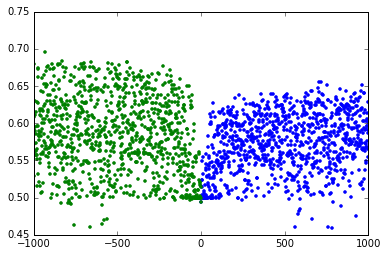

In [108]:
plt.plot(np.arange(0,(num_steps-1)/print_step+1), acc_valid, '.', color='b')
plt.plot((-1)*np.arange(0,(num_steps-1)/print_step+1),acc_test, '.', color='g')
plt.ylim([0.45, 0.75])
plt.xlim([-1000, 1000])

(0.0, 1.0)

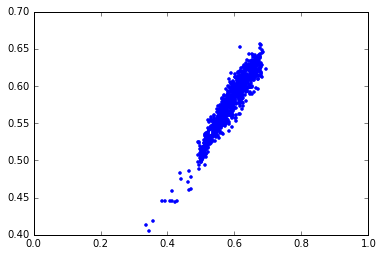

In [120]:
plt.plot(acc_test, acc_valid, '.', color='b')
#plt.plot((-1)*np.arange(0,(num_steps-1)/print_step+1),losses, '.', color='g')
plt.ylim([0.4, 0.7])
plt.xlim([0.0, 1.0])

**Open questions:**
+ Why is there so much scatter in the loss function over time?
+ Is there structure in the loss function over time?
+ If I plot loss vs. accuracy, what do I get? 
+ Do I really see a difference when I scramble vs. leave in order, and if so, is it because of the way SGD interacts with the two cosmologies?
+ will deeper / better networks get us over 65%?
+ Why, oh why, are my test and valid data sets so damn well correlated??

In [124]:
graph.get_tensor_by_name.im_func

<function tensorflow.python.framework.ops.get_tensor_by_name>

---
Problem 1
---------

The convolutional model above uses convolutions with stride 2 to reduce the dimensionality. Replace the strides by a max pooling operation (`nn.max_pool()`) of stride 2 and kernel size 2.

---

---
Problem 2
---------

Try to get the best performance you can using a convolutional net. Look for example at the classic [LeNet5](http://yann.lecun.com/exdb/lenet/) architecture, adding Dropout, and/or adding learning rate decay.

---